In [21]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
from time import time

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy
from sklearn import svm
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool

import random

In [22]:
hisDir = '/oasis/projects/nsf/csd395/ruogu/svm/training/';
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL'];

In [23]:
# Prepare training data
fileNames = os.listdir(hisDir);
Background = [np.load(hisDir + f) for f in fileNames if 'surround' in f];
NonBg = [(np.load(hisDir + f), labels.index(f[:-4])) for f in fileNames if 'surround' not in f];

In [24]:
X = [];
y = [];
for data in NonBg:
    label = data[1];
    for i in range(0, data[0].shape[0]):
        X.append(data[0][i]);
        y.append(label);

bg = [];
for data in Background:
    for i in range(0, data.shape[0]):
        bg.append(data[i]);
#bg = random.sample(bg, 1000);
print len(bg);

X = X + bg;
y = y + ([labels.index('BackG')] * len(bg));
print len(X);
print len(y);

9000
17939
17939


In [25]:
X = np.asarray(X);
y = np.asarray(y);
raw_data = zip(X, y);
random.shuffle(raw_data);
print "%s" %(X.shape,);

(17939, 8400)


In [26]:
quota = 0.8;
n_training = int(len(raw_data)*quota);
n_testing = len(raw_data) - n_training;

In [27]:
print n_training;

14351


In [28]:
training_X = np.asarray([x[0] for x in raw_data[:n_training]]);
training_y = np.asarray([x[1] for x in raw_data[:n_training]]);
testing_X = np.asarray([x[0] for x in raw_data[n_training:]]);
testing_y = np.asarray([x[1] for x in raw_data[n_training:]]);

In [29]:
# Train in parallel.
def train_job(i):
    xi = training_X[i];
    his = 0.5 * np.sum(training_X + xi - np.abs(training_X - xi), axis=1); # Equals to min(xi, xj)
    return (i, his);

start = time();
pool = Pool(processes=16); # This is a compution-heavy work, so we can have more process, like 15.
result_train = pool.map(train_job, range(0, n_training));
end = time();
print "Kernel calculation takes {} sec.".format(end - start);

Kernel calculation takes 10051.407877 sec.


In [30]:
result_train = sorted(result_train, key=lambda x: x[0]);
myKernel = np.asarray([v[1] for v in result_train]);
myKernel = myKernel.reshape(n_training, n_training);

In [31]:
# Train SVM
clf = svm.SVC(kernel="precomputed", decision_function_shape='ovr');
clf.fit(myKernel, training_y);

In [32]:
# Training accuracy
predict_labels_train = clf.predict(myKernel);
n_correct_train = 0;
for i in range(n_training):
    if predict_labels_train[i] == training_y[i]:
        n_correct_train += 1;
print "Training accuracy: {}".format(1.0*n_correct_train / n_training);

Training accuracy: 0.844052679256


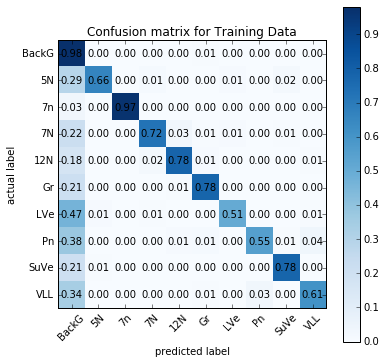

In [33]:
cm_train = confusion_matrix(training_y, predict_labels_train);
cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(6, 6));
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Training Data');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45);
plt.yticks(tick_marks, labels);

ax = fig.add_subplot(111);
for x in xrange(len(labels)):
    for y in xrange(len(labels)):
        ax.annotate(
            "%.2f" % cm_train[x][y], 
            xy=(y, x), 
            horizontalalignment='center',
            verticalalignment='center');

In [34]:
print len(clf.support_);
supp_indices = clf.support_;
supp_vecs = training_X[clf.support_];

11573


In [35]:
# Testing
def test_job(i):
    xi = testing_X[i];
    his = 0.5 * np.sum(training_X + xi - np.abs(training_X - xi), axis=1); # Equals to min(xi, xj)
    return (i, his);

start = time();
pool = Pool(processes=16); # This is a compution-heavy work, so we can have more process, like 15.
result_test = pool.map(test_job, range(0, n_testing));
end = time();
print "Kernel calculation takes {} sec.".format(end - start);

Kernel calculation takes 8251.0932591 sec.


In [36]:
result_test = sorted(result_test, key=lambda x: x[0]);
testKernel = np.asarray([v[1] for v in result_test]);
testKernel = testKernel.reshape(n_testing, n_training);

In [37]:
predict_labels_test = clf.predict(testKernel);
n_correct_test = 0;
for i in range(0, n_testing):
    if (predict_labels_test[i] == testing_y[i]):
        n_correct_test += 1;
print "Test accuracy: {}".format(1.0*n_correct_test / n_testing);

Test accuracy: 0.66276477146


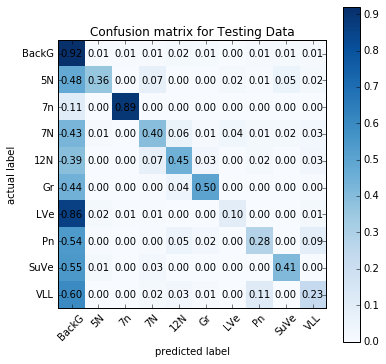

In [38]:
cm_test = confusion_matrix(testing_y, predict_labels_test);
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(6, 6));
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Testing Data');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45);
plt.yticks(tick_marks, labels);

ax = fig.add_subplot(111);
for x in xrange(len(labels)):
    for y in xrange(len(labels)):
        ax.annotate(
            "%.2f" % cm_test[x][y], 
            xy=(y, x), 
            horizontalalignment='center',
            verticalalignment='center');

In [19]:
# np.save('/oasis/projects/nsf/csd395/ruogu/' + exp_id + '/training_X.npy', training_X);

In [20]:
# import pickle
# pickle.dump(clf, open('/oasis/projects/nsf/csd395/ruogu/' + exp_id + '/clf.p', 'wb'));